In [89]:
import torch
import torch_geometric
import networkx as nx
import matplotlib.pyplot as plt

from src.utils import load_data
from src.train.models import GCN
from src.explain.methods import SaliencyMap, GNNExplainer

In [3]:
# define variables
dataset_name = "Cora"
model_name ="gcn"
self_loops = True

# define dataset
dataset = load_data(dataset_name, f"data/Cora")

# load model
model = GCN(dataset.num_features, dataset.num_classes, self_loops)
model.load_state_dict(
    torch.load(
        f"models/{dataset_name}_{model_name}_{self_loops}/state_dict.pt"
    )
)
model.eval()    

# pass elements to correct device
x: torch.Tensor = dataset[0].x.float()
edge_index: torch.Tensor = dataset[0].edge_index.long()
train_mask: torch.Tensor = dataset[0].train_mask
test_mask: torch.Tensor = dataset[0].test_mask
node_ids: torch.Tensor = torch.arange(x.shape[0])
train_node_ids: torch.Tensor = node_ids[train_mask]
test_node_ids: torch.Tensor = node_ids[test_mask]

In [4]:
explainer = SaliencyMap(model)
feature_map = explainer.explain(x, edge_index, 0)

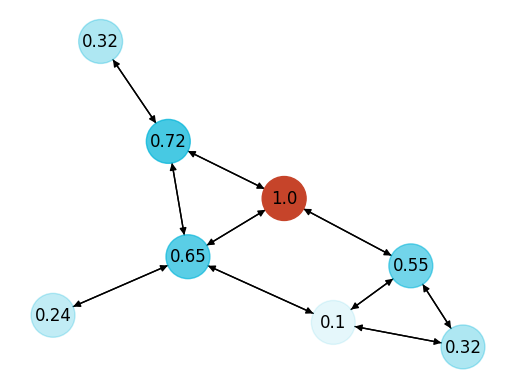

In [88]:
important_node_ids = node_ids[feature_map!=0]

data = torch_geometric.data.Data(x=x, edge_index=edge_index, edge_weight=feature_map)
g = torch_geometric.utils.to_networkx(data)
g = g.subgraph(important_node_ids.tolist())
pos = nx.spring_layout(g, seed=42)  # positions for all nodes
labels = {}
color_map = []
alphas = []
for node in g.nodes():
    #set the node name as the key and the label as its value 
    labels[node] = round(feature_map[node].item(), 2)
    if node != 0:
        color_map.append('#00b4d9')
        alphas.append(float(feature_map[node].item()))
    else: 
        color_map.append('#C6442A')
        alphas.append(float(1.))
        
plt.figure()
nx.draw_networkx_nodes(g, pos=pos, node_color=color_map, node_size=1000, alpha=alphas)
nx.draw_networkx_edges(g, pos=pos, node_size=1000)
nx.draw_networkx_labels(g, pos=pos, labels=labels)
plt.axis('off')
plt.savefig("results/images/saliency_map.pdf", bbox_inches="tight")
plt.show()
plt.close()

In [91]:
explainer = GNNExplainer(model, x, edge_index)
feature_map = explainer.explain(x, edge_index, 0)

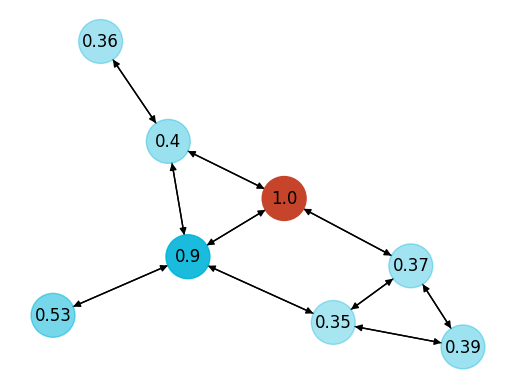

In [92]:
important_node_ids = node_ids[feature_map!=0]

data = torch_geometric.data.Data(x=x, edge_index=edge_index, edge_weight=feature_map)
g = torch_geometric.utils.to_networkx(data)
g = g.subgraph(important_node_ids.tolist())
pos = nx.spring_layout(g, seed=42)  # positions for all nodes
labels = {}
color_map = []
alphas = []
for node in g.nodes():
    #set the node name as the key and the label as its value 
    labels[node] = round(feature_map[node].item(), 2)
    if node != 0:
        color_map.append('#00b4d9')
        alphas.append(float(feature_map[node].item()))
    else: 
        color_map.append('#C6442A')
        alphas.append(float(1.))
        
plt.figure()
nx.draw_networkx_nodes(g, pos=pos, node_color=color_map, node_size=1000, alpha=alphas)
nx.draw_networkx_edges(g, pos=pos, node_size=1000)
nx.draw_networkx_labels(g, pos=pos, labels=labels)
plt.axis('off')
plt.savefig("results/images/gnn_explainer.pdf", bbox_inches="tight")
plt.show()
plt.close()

In [94]:
len(important_node_ids) * 0.1

0.8